# Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization


본 실습에서는, [Grad-CAM](https://arxiv.org/abs/1610.02391) 수치를 계산하고 플롯하는 방법에 대해서 살펴봅니다.

Class activation map(CAM)은 이미지의 특정 부분이 할당된 레이블에 대한 모델의 결정에 영향을 미친 부분을 조사할 수 있는 근거를 제공합니다. 특히 이 방법은 잘못 분류된 샘플을 분석하는 데 특히 유용합니다. Grad-CAM 알고리즘은 매우 직관적이고 구현이 매우 간단합니다.

Grad-CAM을 계산하기까지의 방법은 다음과 같습니다.

- 모델 로드
- 마지막 컨볼루션 레이어 찾기
- 가장 가능성이 높은 클래스 계산
- 얻은 활성화 맵에 대한 클래스 로짓의 기울기를 계산하기
- 그라디언트 풀(Pool the gradients)
- 해당하는 풀링된 그라디언트로 맵의 채널에 가중치 부여
- 히트맵 보간(Interpolate)


우선 `torchvision` 에서 모델을 로드하고 Transform함수와 데이터 로더를 준비합니다.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.models import vgg19
import cv2
import torch.nn.functional as F

inv_norm = transforms.Normalize((-0.4914/0.2023, -0.4822/0.1994, -0.4465/0.2010), (1/0.2023, 1/0.1994, 1/0.2010))
dataset  = torchvision.datasets.CIFAR10(root='./data/cifar', train=False, download=True,
                                           transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),]))

dataloader  = torch.utils.data.DataLoader(dataset , batch_size=1, shuffle=True, num_workers=8)

100%|██████████| 170498071/170498071 [00:03<00:00, 43492394.63it/s]


Extracting ./data/cifar/cifar-10-python.tar.gz to ./data/cifar


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Model Wrapper

`ResNet`에 wrapper 클래스를 정의하여, k번째 레이어에서 gradient를 얻을 수 있게 바꿈.

https://pytorch.org/docs/stable/autograd.html#torch.Tensor.register_hook

일부 작업은 역전파을 실행하는중에 나오는 중간 결과를 저장해야 할 수 있으며, 이를 위해 우리는 hook를 사용하여 역전파 중간과정의 텐서를 가져오는 방식을 정의할 수 있습니다.

In [124]:
class ResNet_CAM(nn.Module):
    def __init__(self, net, layer_k):
        super(ResNet_CAM, self).__init__()
        self.resnet = net
        convs = nn.Sequential(*list(net.children())[:-1])

        # k번째 레이어까지 첫번째 파트, 나머지는 두번째 파트로 구분
        self.first_part_conv = convs[:layer_k]
        self.second_part_conv = convs[layer_k:]
        self.linear = nn.Sequential(*list(net.children())[-1:])

    def forward(self, x):
        x = self.first_part_conv(x)

        # hook 콜백함수 등록
        # Autograd의 backward함수는 모든 역전파 과정을 자동화 하므로,
        # 중간 gradient (중간 activation에 대한 예측 y의 변화율)를 얻기 위해서
        # gradient hook을 등록해야함
        x.register_hook(self.activations_hook)
        x = self.second_part_conv(x)
        x = F.adaptive_avg_pool2d(x, (1,1))
        x = x.view((1, -1))
        x = self.linear(x)
        return x

    def activations_hook(self, grad):
        self.gradients = grad

    def get_activations_gradient(self):
        # 목표로 하는 conv layer의 엑티베이션에 해당하는 gradient를 가져옴
        return self.gradients

    def get_activations(self, x):
        return self.first_part_conv(x)

## Models From `torch.hub`

Next, we load in the models from `torch.hub`

In [125]:
baseline_net = torch.hub.load('ecs-vlc/FMix:master', 'preact_resnet18_cifar10_baseline', pretrained=True)

Using cache found in /root/.cache/torch/hub/ecs-vlc_FMix_master


## Grad-CAM

Step 1: Compute Gradient


Step 1. feature map activation(A)에 대한 타켓 클래스 점수 (Yc)의 gradient를 계산한다.

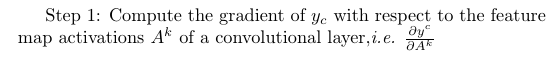


In [151]:
# 모델과 테스트 이미지
layer_k = 5
model = ResNet_CAM(baseline_net, layer_k)
img, _ = next(iter(dataloader))

# 이미지 클래스 예측
model.eval()
pred = model(img)

# 가장 높은 예측값을 가진 값을 가져온다
pred = pred[:,pred.argmax(dim=1)]

# 모델에 따른 출력의 gradient값을 계산하도록 함
pred.backward()

# 모델의 중간 gradient값을 가져옴
gradients = model.get_activations_gradient()

Step 2. Global average pooling

이미지의 x,y값 전체에 대한 평균값을 구한다.

**[힌트]**
- 위에서 구한 `gradient` 텐서의 shape는 다음과 같다. `[batch_size, channel, height, width]`

- 여기서 우리는 각 channel별 평균값을 구하기 위해, 이미지의 `height, width`에 대한 값에 평균을 취한다.

- 입력 `batch_size`는 1이므로, 해당 차원은 없애도 무방함.


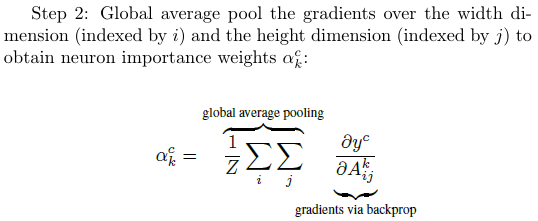


In [152]:
gradients.shape #batch_size, chanel, height, width

torch.Size([1, 256, 8, 8])

In [153]:
# gradient GAP
# torch.mean() 함수를 이용함

############## 코드 작성 필요 ###############

alpha_k = torch.mean(gradients, axis = (2,3))

#############################################



In [155]:
alpha_k.shape

torch.Size([1, 256])

Step 3. Feature map activation과 위에서 구한 가중치를 곱한다.
최종 결과에 양수값만 표시하기 위해 ReLU를 적용한다.

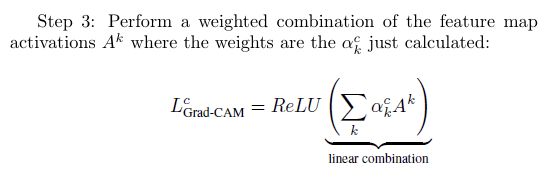



In [156]:
activations = model.get_activations(img).detach()
activations.shape

torch.Size([1, 256, 8, 8])

In [158]:
# get the activations of the last convolutional layer
activations = model.get_activations(img).detach()

############## 코드 작성 필요 ###############
# weight the channels by corresponding gradients
for i in range(activations.size(1)):
    activations[:, i, :, :] *= alpha_k[0, i]


#############################################

# average the channels of the activations
activation_map = torch.mean(activations, dim=1).squeeze()

# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
activation_map = np.maximum(activation_map, 0)

# normalize the heatmap
activation_map /= torch.max(activation_map)


위 activation map을 시각화 해보자.

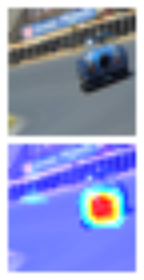

In [159]:
# 시각화
def superimpose_heatmap(heatmap, img):
    # 색상 시각화 코드
    # The original code is written by François Chollet
    resized_heatmap = cv2.resize(heatmap.numpy(), (img.shape[2], img.shape[3]))
    resized_heatmap = np.uint8(255 * resized_heatmap)
    resized_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    superimposed_img = torch.Tensor(cv2.cvtColor(resized_heatmap, cv2.COLOR_BGR2RGB)) * 0.006 + inv_norm(img[0]).permute(1,2,0)

    return superimposed_img


from google.colab.patches import cv2_imshow
import cv2

# 원본과 activation map 저장
imgs = torch.Tensor(2, 1, 3, 32, 32)
imgs[0][0] = inv_norm(img[0])
imgs[1][0] = torch.Tensor(superimpose_heatmap(activation_map, img).permute(2,0,1))

# torchvision util 사용 시각화
torchvision.utils.save_image(imgs.view(-1, 3, 32, 32), "gradcam_at_layer" + str(layer_k) + ".png",nrow=1, pad_value=1)
imgs = cv2.imread("gradcam_at_layer" + str(layer_k) + ".png")
cv2_imshow(cv2.resize(imgs, (0, 0), fx=4, fy=4))


## 실습 과제
1. 위 과정을 전부 합쳐서 하나의 function으로 구성하여 시각화를 해보자.

2. 아래 작성한 get_grad_cam 함수의 코드 단계(line)별 tensor의 shape와 그 기능/의미에 대해 comment로 작성하시오.


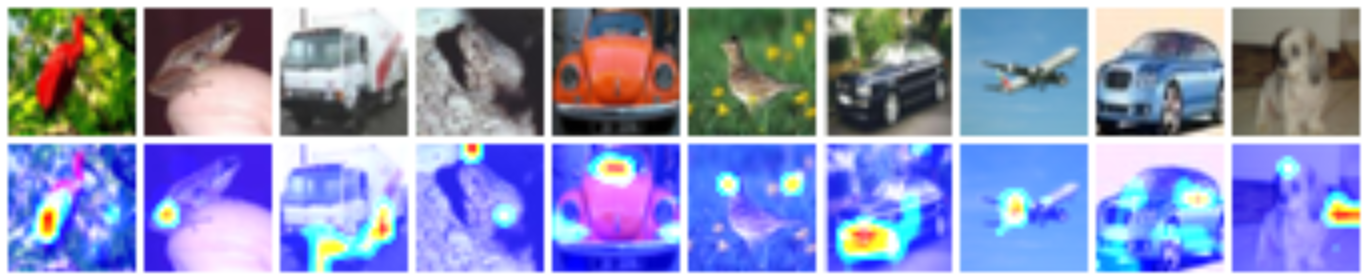

In [161]:
from google.colab.patches import cv2_imshow
import cv2

def get_grad_cam(net, img):
    # 이미지 클래스 예측
    net.eval()
    pred = net(img)

    ########## 코드 작성 필요 #############

    # 가장 높은 예측값을 가진 값을 가져온다
    pred = pred[:,pred.argmax(dim=1)]

    # 모델에 따른 출력의 gradient값을 계산하도록 함
    pred.backward()

    # 모델의 중간 gradient값을 가져옴
    gradients = model.get_activations_gradient()

    #위에서 구한 gradient map의 x, y축에 대한 (i,j-index) 평균을 구한다.
    alpha_k = torch.mean(gradients, axis = (2,3))


    #마지막 convlo convolutional layer의 활성화를 가져온다.
    activations = model.get_activations(img).detach()

    # linear combination
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= alpha_k[0, i]

    #각 채널의 활성화의 평균을 구한다
    heatmap = torch.mean(activations, dim=1).squeeze()

    # ReLU를 적용한다
    heatmap = np.maximum(heatmap, 0)

    # heatmap 정규화
    heatmap /= torch.max(heatmap)


    #######################################

    return torch.Tensor(superimpose_heatmap(heatmap, img).permute(2,0,1))


layer_k = 10
n_imgs = 10

baseline_cam_net = ResNet_CAM(baseline_net, layer_k)

imgs = torch.Tensor(2, n_imgs, 3, 32, 32)
it = iter(dataloader)
for i in range(0,n_imgs):
    img, _ = next(it)
    imgs[0][i] = inv_norm(img[0])
    imgs[1][i] = get_grad_cam(baseline_cam_net, img)

torchvision.utils.save_image(imgs.view(-1, 3, 32, 32), "gradcam_at_layer" + str(layer_k) + ".png",nrow=n_imgs, pad_value=1)
imgs = cv2.imread("gradcam_at_layer" + str(layer_k) + ".png")
cv2_imshow(cv2.resize(imgs, (0, 0), fx=4, fy=4))